# Building a Demand Forcasting Model Using PySpark


It's simple to buy any product with a click and have it delivered to your door. Online shopping has been rapidly evolving over the last few years, making our lives easier. But behind the scenes, e-commerce companies face a complex challenge that needs to be addressed. 

Uncertainty plays a big role in how the supply chains plan and organize their operations to ensure that the products are delivered on time. These uncertainties can lead to challenges such as stockouts, delayed deliveries, and increased operational costs.

You work for the Sales & Operations Planning (S&OP) team at a multinational e-commerce company. They need your help to assist in planning for the upcoming end-of-the-year sales. They want to use your insights to plan for promotional opportunities and manage their inventory. This effort is to ensure they have the right products in stock when needed and ensure their customers are satisfied with the prompt delivery to their doorstep.


## The Data

You are provided with a sales dataset to use. A summary and preview are provided below.

# Online Retail.csv

| Column     | Description              |
|------------|--------------------------|
| `'InvoiceNo'` | A 6-digit number uniquely assigned to each transaction |
| `'StockCode'` | A 5-digit number uniquely assigned to each distinct product |
| `'Description'` | The product name |
| `'Quantity'` | The quantity of each product (item) per transaction |
| `'UnitPrice'` | Product price per unit |
| `'CustomerID'` | A 5-digit number uniquely assigned to each customer |
| `'Country'` | The name of the country where each customer resides |
| `'InvoiceDate'` | The day and time when each transaction was generated `"MM/DD/YYYY"` |
| `'Year'` | The year when each transaction was generated |
| `'Month'` | The month when each transaction was generated |
| `'Week'` | The week when each transaction was generated (`1`-`52`) |
| `'Day'` | The day of the month when each transaction was generated (`1`-`31`) |
| `'DayOfWeek'` | The day of the weeke when each transaction was generated <br>(`0` = Monday, `6` = Sunday) |

## Importing necessary Libraries and the dataset used:

In [27]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col, dayofmonth, month, year,  to_date, to_timestamp, weekofyear, dayofweek
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark session
my_spark = SparkSession.builder.appName("SalesForecast").getOrCreate()

# Importing sales data
sales_data = my_spark.read.csv(
    "Online Retail.csv", header=True, inferSchema=True, sep=",")

# Convert InvoiceDate to datetime 
sales_data = sales_data.withColumn("InvoiceDate", to_date(
    to_timestamp(col("InvoiceDate"), "d/M/yyyy H:mm")))

## Data Preprocessing: 

In [28]:
#Verify the type of our dataset
type(sales_data)

pyspark.sql.dataframe.DataFrame

In [3]:
sales_data.printSchema()

root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)



In [4]:
sales_data.show()

+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+
|InvoiceNo|StockCode|         Description|Quantity|UnitPrice|CustomerID|       Country|InvoiceDate|Year|Month|Week|Day|DayOfWeek|
+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+
|   536365|   85123A|WHITE HANGING HEA...|       6|     2.55|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|    71053| WHITE METAL LANTERN|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84406B|CREAM CUPID HEART...|       8|     2.75|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84029G|KNITTED UNION FLA...|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|     3.39|     17850|United Kingdom| 20

In [29]:
print("number of rows:",sales_data.count())
print("number of columns:", len(sales_data.columns))
print("columns names:", sales_data.columns)

number of rows: 384721
number of columns: 13
columns names: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 'Country', 'InvoiceDate', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek']


In [29]:
sales_data.describe().show()

+-------+------------------+------------------+--------------------+-----------------+-----------------+------------------+-----------+------------------+-----------------+------------------+-----------------+------------------+
|summary|         InvoiceNo|         StockCode|         Description|         Quantity|        UnitPrice|        CustomerID|    Country|              Year|            Month|              Week|              Day|         DayOfWeek|
+-------+------------------+------------------+--------------------+-----------------+-----------------+------------------+-----------+------------------+-----------------+------------------+-----------------+------------------+
|  count|            384721|            384721|              384721|           384721|           384721|            384721|     384721|            384721|           384721|            384721|           384721|            384721|
|   mean| 560650.5626960837|27337.415763815174|                null|8.30641165935834

In [33]:
from pyspark.sql.functions import col, sum
# Check for null values in each column
null_counts = sales_data.select([sum(col(c).isNull().cast("int")).alias(c) for c in sales_data.columns])
null_counts.show()

+---------+---------+-----------+--------+---------+----------+-------+-----------+----+-----+----+---+---------+
|InvoiceNo|StockCode|Description|Quantity|UnitPrice|CustomerID|Country|InvoiceDate|Year|Month|Week|Day|DayOfWeek|
+---------+---------+-----------+--------+---------+----------+-------+-----------+----+-----+----+---+---------+
|        0|        0|          0|       0|        0|         0|      0|          0|   0|    0|   0|  0|        0|
+---------+---------+-----------+--------+---------+----------+-------+-----------+----+-----+----+---+---------+



In [30]:
#check if there is any duplicate rows
total_rows = sales_data.count()
distinct_rows = sales_data.distinct().count()
duplicate_count = total_rows - distinct_rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 5179


In [31]:
# Drop duplicate rows
sales_data = sales_data.dropDuplicates()

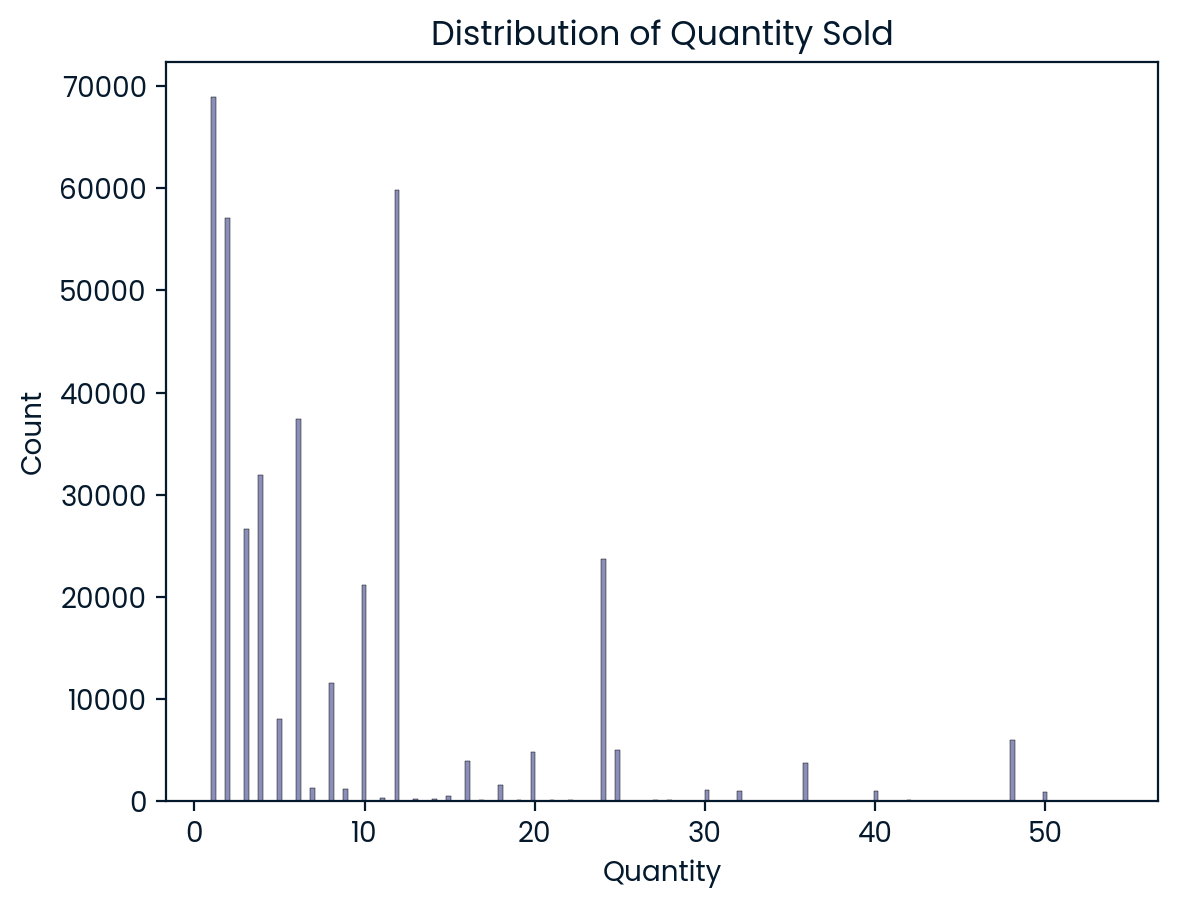

In [8]:
sales_data_pd = sales_data.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sales_data_pd['Quantity'])
plt.title('Distribution of Quantity Sold')
plt.show()

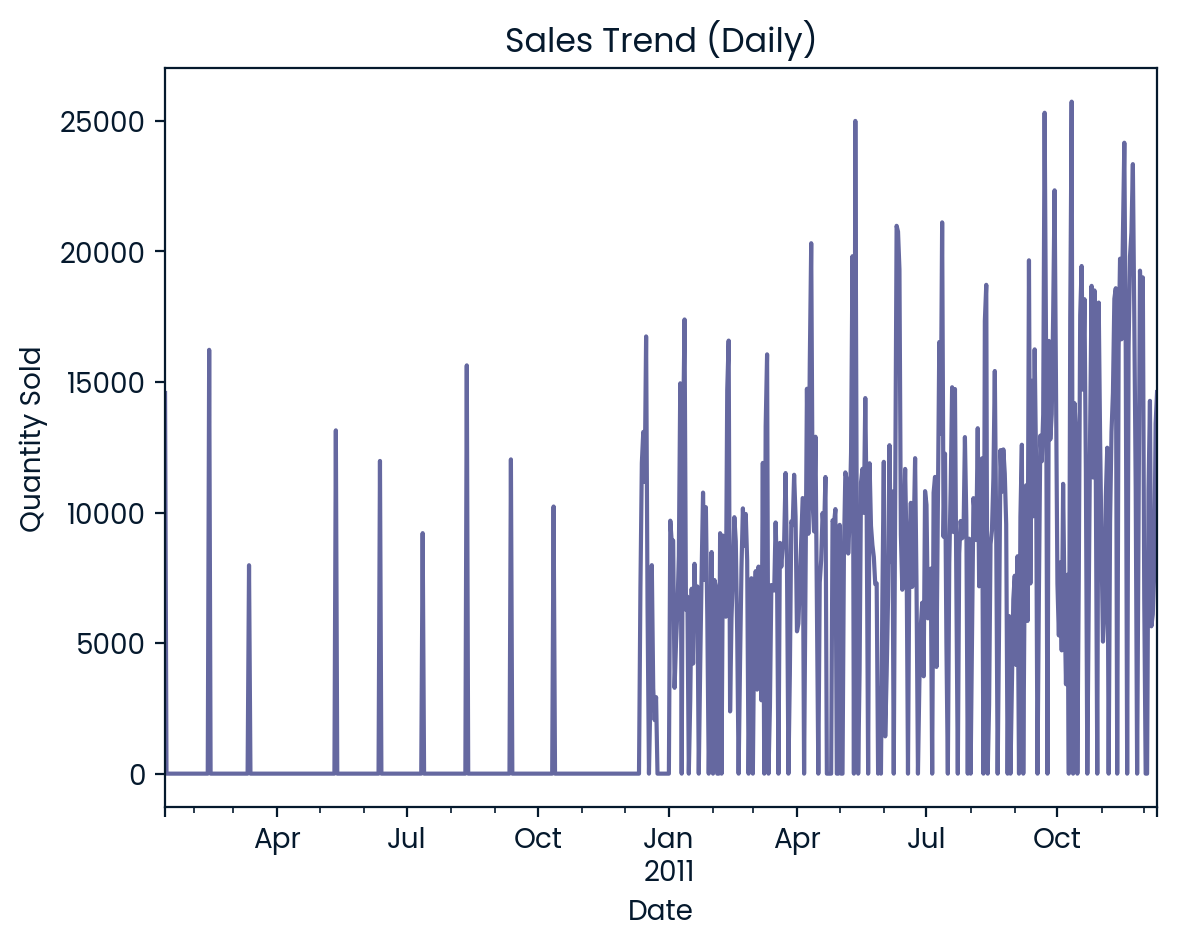

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Correcting the method to convert 'InvoiceDate' to datetime
sales_data_pd['InvoiceDate'] = pd.to_datetime(sales_data_pd['InvoiceDate'])
sales_data_pd.set_index('InvoiceDate', inplace=True)

# You can reset the index later if you want to retain 'InvoiceDate' as a column
sales_data_pd.reset_index(inplace=True)

# Now you can resample and plot
sales_data_pd.set_index('InvoiceDate', inplace=True)  # Make sure 'InvoiceDate' is the index
sales_data_pd.resample('D')['Quantity'].sum().plot()  # Daily sales
plt.title('Sales Trend (Daily)')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

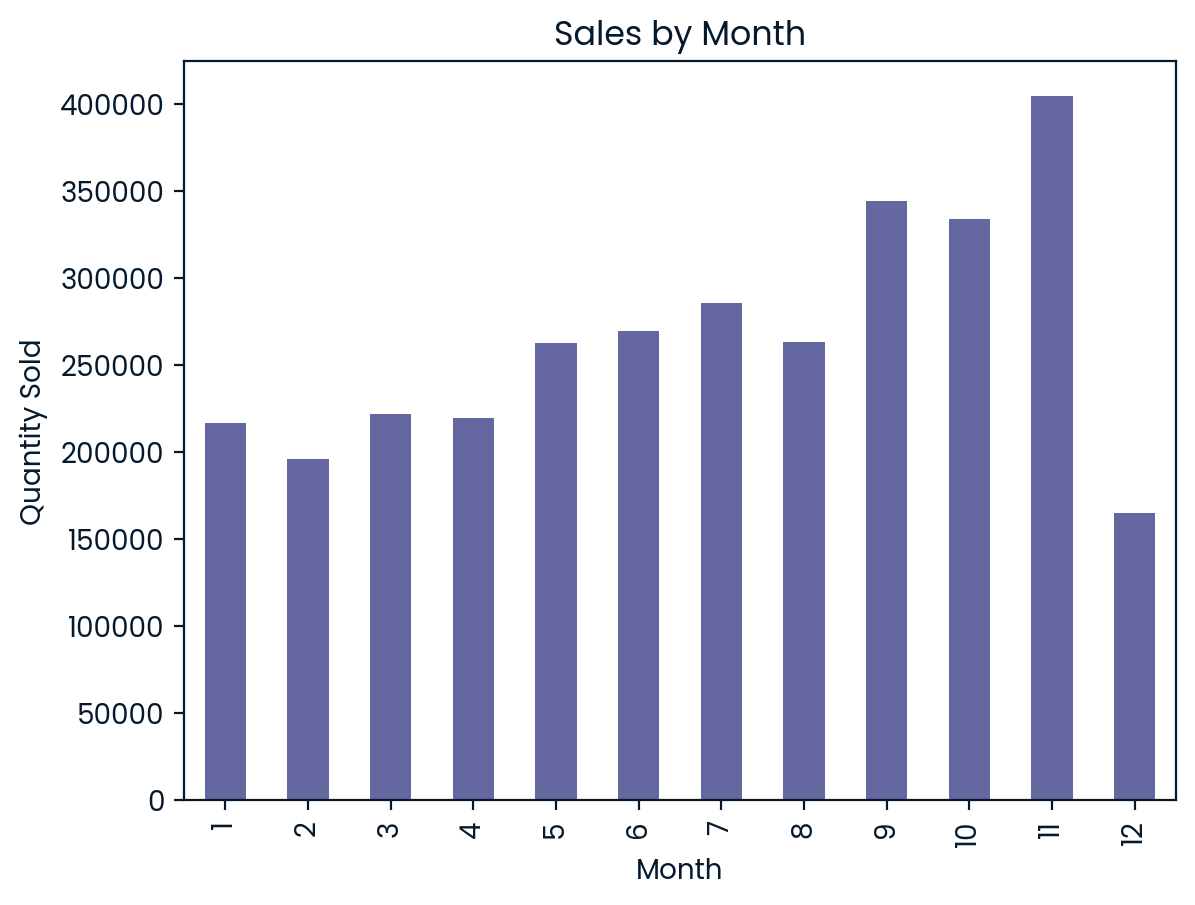

In [11]:
sales_data_pd.reset_index(inplace=True)

monthly_sales = sales_data_pd.groupby(sales_data_pd['InvoiceDate'].dt.month)['Quantity'].sum()
monthly_sales.plot(kind='bar')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.show()

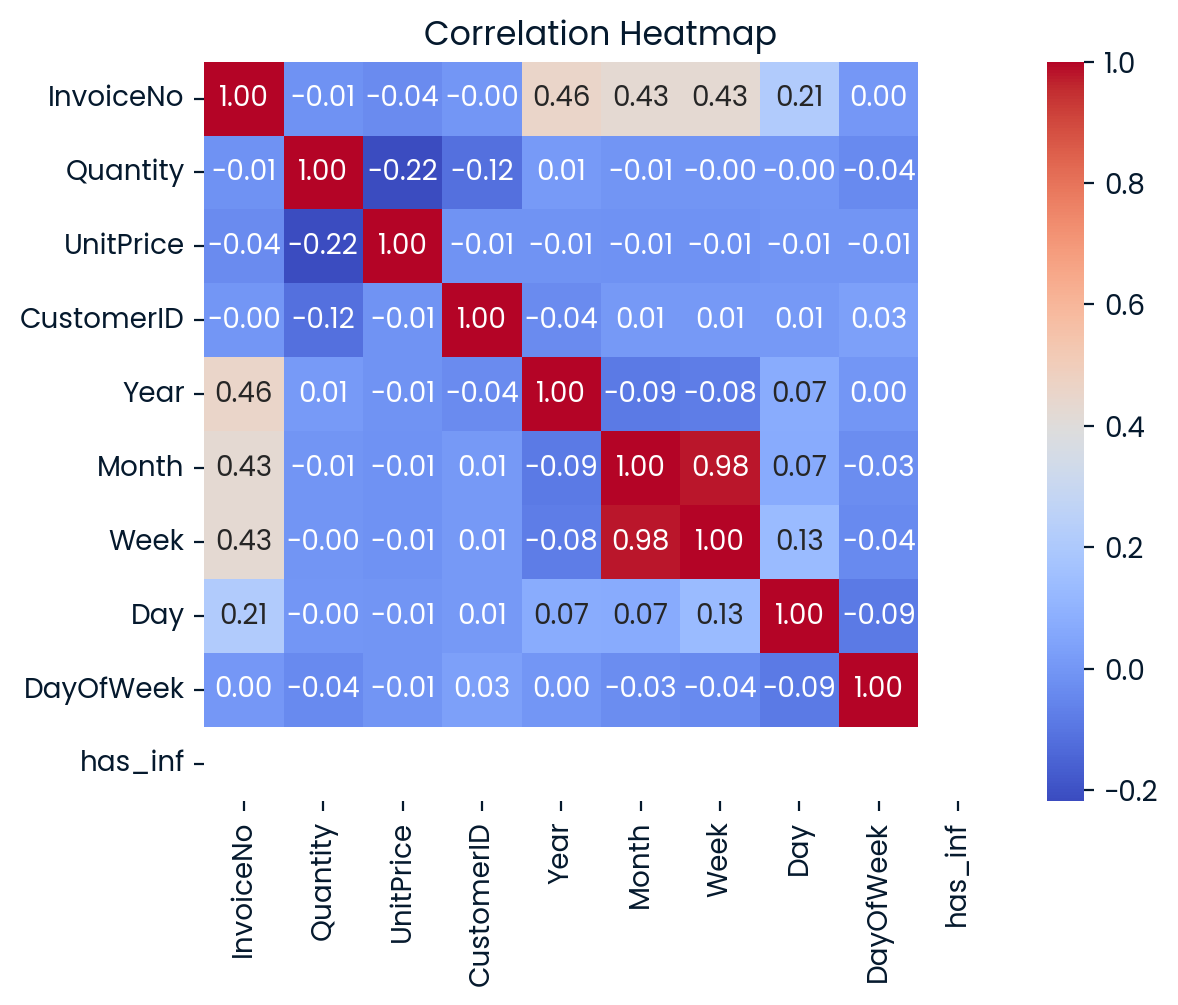

In [55]:
#the correlation matrix:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = sales_data_pd.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Aggregating the data:

In [32]:
# Group the data by the specified columns and perform the required aggregations
daily_sales = sales_data.groupBy(
    "Country", "StockCode", "InvoiceDate", "Year", "Month", "Day", "Week", "DayOfWeek"
).agg({"Quantity": "sum", "UnitPrice": "avg"})
# Rename the aggregated "sum(Quantity)" column to "Quantity" for consistency
daily_sales = daily_sales.withColumnRenamed("sum(Quantity)", "Quantity") \
                           .withColumnRenamed("avg(UnitPrice)", "AvgUnitPrice")

In [41]:
daily_sales = daily_sales.orderBy("InvoiceDate")

In [42]:
# Show the resulting DataFrame
daily_sales.show()

+--------------+---------+-----------+----+-----+---+----+---------+-----------------+--------+
|       Country|StockCode|InvoiceDate|Year|Month|Day|Week|DayOfWeek|     AvgUnitPrice|Quantity|
+--------------+---------+-----------+----+-----+---+----+---------+-----------------+--------+
|United Kingdom|   84884A| 2010-01-12|2010|    1| 12|   2|        1|             3.95|      10|
|United Kingdom|    21657| 2010-01-12|2010|    1| 12|   2|        1|             6.95|       1|
|United Kingdom|    21761| 2010-01-12|2010|    1| 12|   2|        1|            29.95|       1|
|United Kingdom|    22912| 2010-01-12|2010|    1| 12|   2|        1|             4.95|       3|
|United Kingdom|    21813| 2010-01-12|2010|    1| 12|   2|        1|             4.95|       1|
|United Kingdom|    21668| 2010-01-12|2010|    1| 12|   2|        1|             1.25|      18|
|United Kingdom|    22321| 2010-01-12|2010|    1| 12|   2|        1|             0.85|      13|
|United Kingdom|    21544| 2010-01-12|20

## Splitting the data:

In [36]:
# Define the split date
split_date = "2011-09-25"

In [38]:
# Filter data to create the train and test sets based on the split date
train_data = daily_sales.filter(col("InvoiceDate") <= split_date)
test_data = daily_sales.filter(col("InvoiceDate") > split_date)

In [39]:
# Convert the train_data to a pandas DataFrame
pd_daily_train_data = train_data.toPandas()

In [40]:
# Show the results
print("Train Data (first 5 rows):")
print(pd_daily_train_data.head())
print("\nTest Data:")
test_data.show()

Train Data (first 5 rows):
          Country StockCode InvoiceDate  ...  DayOfWeek  AvgUnitPrice  Quantity
0  United Kingdom     22931  2011-09-01  ...          3          2.55         3
1  United Kingdom     22029  2011-05-01  ...          6          0.42        24
2  United Kingdom     22623  2011-05-01  ...          6          4.95         1
3  United Kingdom     21620  2011-07-01  ...          4          1.25        12
4  United Kingdom     22772  2011-04-01  ...          4          1.25        12

[5 rows x 10 columns]

Test Data:


+--------------+---------+-----------+----+-----+---+----+---------+------------------+--------+
|       Country|StockCode|InvoiceDate|Year|Month|Day|Week|DayOfWeek|      AvgUnitPrice|Quantity|
+--------------+---------+-----------+----+-----+---+----+---------+------------------+--------+
|        France|    21429| 2011-10-01|2011|   10|  1|  39|        5|              1.65|       8|
|United Kingdom|    22772| 2011-12-01|2011|   12|  1|  48|        3|              1.25|      12|
|United Kingdom|    21874| 2011-10-01|2011|   10|  1|  39|        5|              1.25|      12|
|United Kingdom|   82494L| 2011-12-01|2011|   12|  1|  48|        3|              2.75|      25|
|         Spain|   85132B| 2011-10-01|2011|   10|  1|  39|        5|              9.95|       1|
|United Kingdom|    21733| 2011-11-01|2011|   11|  1|  44|        1|2.8499999999999996|      46|
|United Kingdom|    22560| 2011-12-01|2011|   12|  1|  48|        3|              1.06|      48|
|United Kingdom|    21874| 201

## Building the Random Forest Regression Model:

### 1. Indexing Categorical Columns
We need to encode categorical columns (Country and StockCode) into numerical values that the model can work with. For this, we use StringIndexer, which will create numerical indices for each category in the columns. Additionally, we set .setHandleInvalid("keep") to handle any new categories in the test data that weren’t in the training data.

In [43]:
country_indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex").setHandleInvalid("keep")
stock_code_indexer = StringIndexer(inputCol="StockCode", outputCol="StockCodeIndex").setHandleInvalid("keep")

### 2. Vectorizing Features
After encoding the categorical variables, we need to combine all the features into a single vector column. This is done using VectorAssembler. This will allow us to pass a single vector column as input to the Random Forest model.

In [44]:
input_features = ["CountryIndex", "StockCodeIndex", "Year", "Month", "Day", "Week", "DayOfWeek", "AvgUnitPrice"]
assembler = VectorAssembler(inputCols=input_features, outputCol="features")

### 3. Configuring the Random Forest Regressor
We’ll use RandomForestRegressor to create a regression model that predicts Quantity. We need to set:
- featuresCol to the name of the vectorized features (e.g., "features").
- labelCol to the target variable (Quantity).
- maxBins = 4000 to handle the potentially large number of unique values in the categorical features.

In [45]:
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="Quantity", 
    maxBins=4000
)

### 4. Creating a Pipeline
A Pipeline allows us to streamline the process, chaining all transformations and model training steps together. This makes it easier to fit the pipeline to the training data and then apply the transformations consistently to the test data.

In [46]:
pipeline = Pipeline(stages=[country_indexer, stock_code_indexer, assembler, rf])

In [47]:
# Training the model
model = pipeline.fit(train_data)

24/11/10 18:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB


24/11/10 18:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1738.3 KiB


24/11/10 18:01:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


## Model Evaluation:

### Step 1: Make Predictions:
We will use the .transform() method on the test data to generate predictions. Then, to ensure the predictions are in a consistent format, we’ll cast the "prediction" column to a double data type.

In [48]:
# Getting test predictions
test_predictions = model.transform(test_data)
test_predictions = test_predictions.withColumn("prediction", col("prediction").cast("double"))

### Step 2: Calculate Mean Absolute Error (MAE)
We’ll use RegressionEvaluator to evaluate the model’s performance, setting it to use the MAE metric.

In [49]:
mae_evaluator = RegressionEvaluator(
    labelCol="Quantity", 
    predictionCol="prediction", 
    metricName="mae"
)

In [50]:
# Calculate MAE
mae = mae_evaluator.evaluate(test_predictions)

In [52]:
# Display the Mean Absolute Error
print(f"Mean Absolute Error (MAE) on test data: {mae}")

Mean Absolute Error (MAE) on test data: 9.205692917246799


## Identify the quantity sold at specific week

In [53]:
# Step 1: Group by Year and Week, calculate sum of predicted quantity
weekly_sales = test_predictions.groupBy("Year", "Week").agg({"prediction": "sum"})

In [54]:
# Step 2: Filter for Week 39 of 2011
week_39_sales = weekly_sales.filter((col("Year") == 2011) & (col("Week") == 39))

In [55]:
# Step 3: Get the predicted quantity for Week 39
quantity_sold_w39 = week_39_sales.select("sum(prediction)").collect()[0][0]

In [56]:
# Convert the result to an integer
quantity_sold_w39 = int(quantity_sold_w39)

In [57]:
# Display the result
print(f"Predicted quantity sold during Week 39 of 2011: {quantity_sold_w39}")

Predicted quantity sold during Week 39 of 2011: 87216


In [59]:
actual_sales_week_39 = sales_data.filter(
    (col("Year") == 2011) & (col("Week") == 39)
).agg({"Quantity": "sum"}).collect()[0][0]

In [60]:
print(f"Actual quantity sold during Week 39 of 2011: {actual_sales_week_39}")

Actual quantity sold during Week 39 of 2011: 93646


In [61]:
# Step 3: Calculate the difference to assess prediction accuracy
difference = abs(quantity_sold_w39 - actual_sales_week_39)
print(f"Difference between predicted and actual sales: {difference}")

Difference between predicted and actual sales: 6430


In [ ]:
# Stop the Spark session
my_spark.stop()